## Welcome to the `Efficient Self-Attention Intuition` Workshop!
In this workshop, we'll try to visually understand following concepts:
- Overlap Patch Embedding / Merging
- Efficient Self Attention

### Library imports

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
os.chdir("/content/drive/My Drive/thinkAutonomous/image_segmentation/finalContent")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# basic imports
import pickle
import numpy as np
import matplotlib.pyplot as plt    

# utility library for transforming tensors
!pip install -q einops
!pip install -q ipympl    
!pip install -q segmentation-models-pytorch
from einops import rearrange

# enable custom widgets
from google.colab import output
output.enable_custom_widget_manager()

### Read input data

In [ ]:
with open('dataset/attention_concept_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(data.keys())

dict_keys(['key', 'query', 'value', 'attn', 'rgb_img', 'tf_img', 'patch_embed_output'])


In [ ]:
print(data['rgb_img'].shape)

(512, 1024, 3)


### Plot the Image

In [ ]:
def plot_single_channel_image(inputData, figsize, figTitle, save_plot = False, cmap=None,
                            plot_colorbar = False):
    fig = plt.figure(figsize=figsize)
    im = plt.imshow(inputData, cmap = cmap)
    plt.suptitle(figTitle);
    plt.axis('off');   
    
    if(plot_colorbar):    
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)

    if(save_plot):
        plt.savefig(f"{figTitle}.png")    

### Show the Input Image

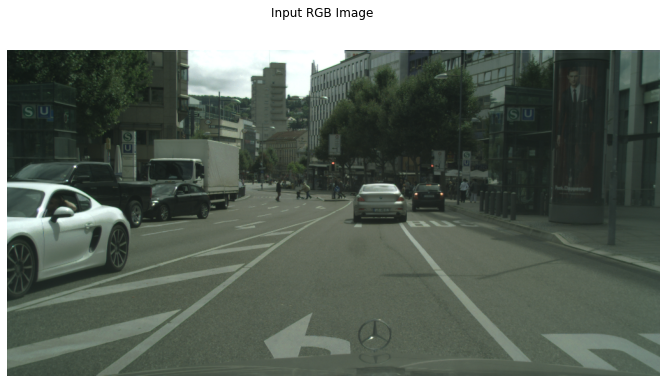

In [ ]:
plot_single_channel_image(data['rgb_img'], (12,6), 'Input RGB Image')

## Overlap patch Embedding / Merging
- Entire image is split into patches which are passed to consequent Transformer blocks
- This layer acts like Embedding layer using Convolution layers
- Initial stage outputs indicate low-level features like edge detection and more abstract features in later stages 

In [ ]:
def plot_channels(inputData, num_rows, num_cols, figsize, figTitle, save_plot = False, cmap=None,
                  plot_colorbar = False):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if(num_rows * num_cols == 1):
        axes = [axes]
    else:
        axes = axes.flatten()

    num_data_channels = inputData.shape[0]
    for i in range(len(axes)):
        if(i < num_data_channels):
            im = axes[i].imshow(inputData[i], cmap=cmap)
        axes[i].axis('off')    
        fig.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(figTitle);

    if(plot_colorbar):    
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)

    if(save_plot):
        fig.savefig(f"{figTitle}.png")

patch_embed_output.shape = (32768, 64)
patch_embed_img.shape = (64, 128, 256)


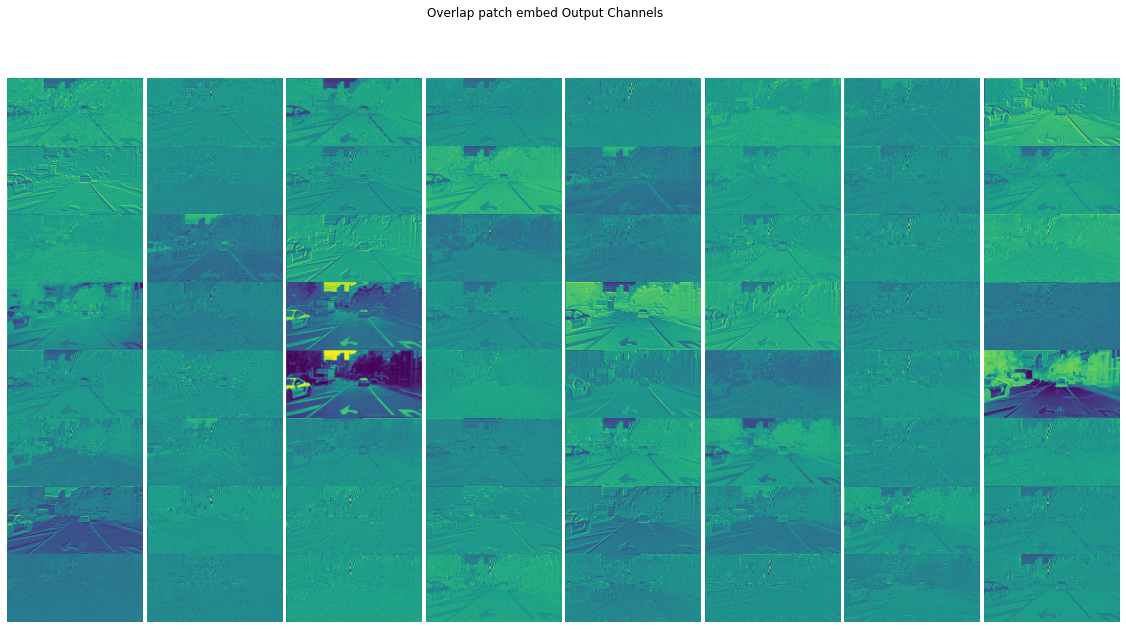

In [ ]:
# read patch embedding layer output
patch_embed_output = data['patch_embed_output'][0]
print(f"patch_embed_output.shape = {patch_embed_output.shape}")

patch_embed_img = rearrange(patch_embed_output, '(h w) c -> c h w', h=128, w=256)
print(f"patch_embed_img.shape = {patch_embed_img.shape}")

# plot each channel of patch embedding 
plot_channels(patch_embed_img, 8, 8, (20,10), 'Overlap patch embed Output Channels')

## Attention mechanism
- Attention mechanism involves 3 components - **Query, Key and Value**
- It is a mapping of a query and a set of key-value pairs to an output,
- Output is computed as a weighted sum of the values, where the weight assigned to each value is computed by similarity b/w query and corresponding key

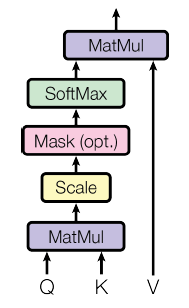

[Image reference](https://arxiv.org/abs/1706.03762)

**NOTE**
- Keys refer to input space (eg : embedded version of image coordinates)
- Query refers to output space (eg : Euclidean space in metres)
- Value can be any property in output space (eg: Depth, Speed of object at that location etc) 

## Query Visualization
- Query tries to match with certain features of specific type

query_img.shape = (64, 128, 256)


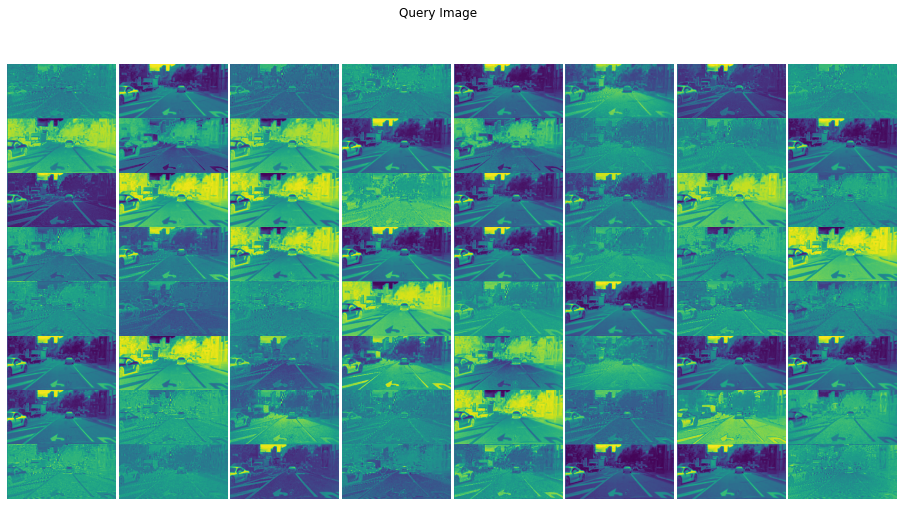

In [ ]:
# query for first stage first block of transformer
query = data['query'][0][0]
query_img = rearrange(query, '(h w) c -> c h w', h=128, w=256)
print(f"query_img.shape = {query_img.shape}")

# plot each channel of Query 
plot_channels(query_img, 8, 8, (16,8), 'Query Image')

## Key Visualization
- Key vector encodes that it's part of some object at some pixel location in input space and looking for features of specific type
- In Efficient self-attention, Key vector is << Query and hence appears pixelated

key_img.shape = (64, 16, 32)


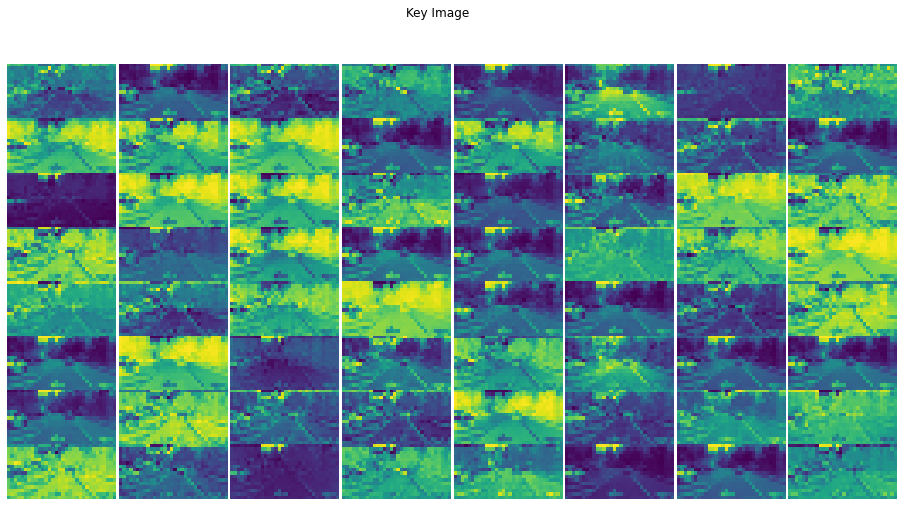

In [ ]:
# key for first stage first block of transformer
key = data['key'][0][0]
key_img = rearrange(key, '(h w) c -> c h w', h=16, w=32)
print(f"key_img.shape = {key_img.shape}")

# plot each channel of Key of Transformer 
plot_channels(key_img, 8, 8, (16,8), 'Key Image')

## Attention mechanism

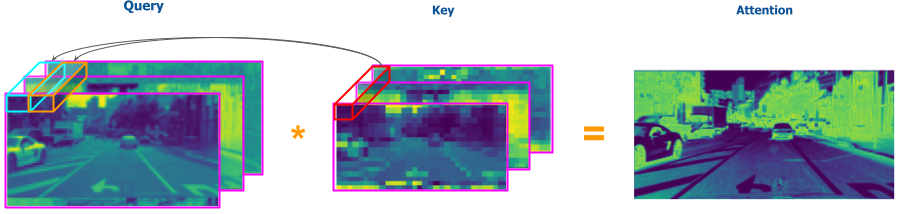

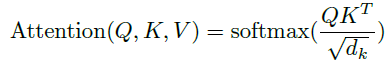

- Dot product is computed b/w each pixel combination in Query and Key matrices
- Output is scaled by key dimension and then softmax is applied
- Here, First pixel in Key contains **dark colored pixel** and we're comparing this feature with all pixels in Query Matrix
- **Pixels where query is similar to key (dark colored pixel) are given more weight in Attention output**


## Attention Visualization

attention_img.shape = (128, 256)


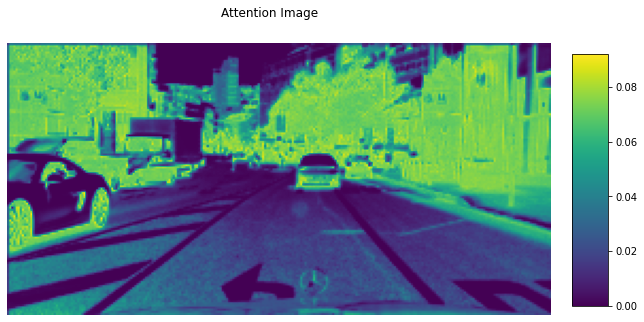

In [ ]:
# Attention of 1st pixel in key w.r.t all Query pixels
attention = data['attn'][0, :, :, 0]
attention_img = attention.reshape(128,256)
print(f"attention_img.shape = {attention_img.shape}")
plot_single_channel_image(attention_img, (10,5), 'Attention Image', save_plot=True, plot_colorbar=True)

## ROI selection

Button(description='Disconnect mpl', style=ButtonStyle())

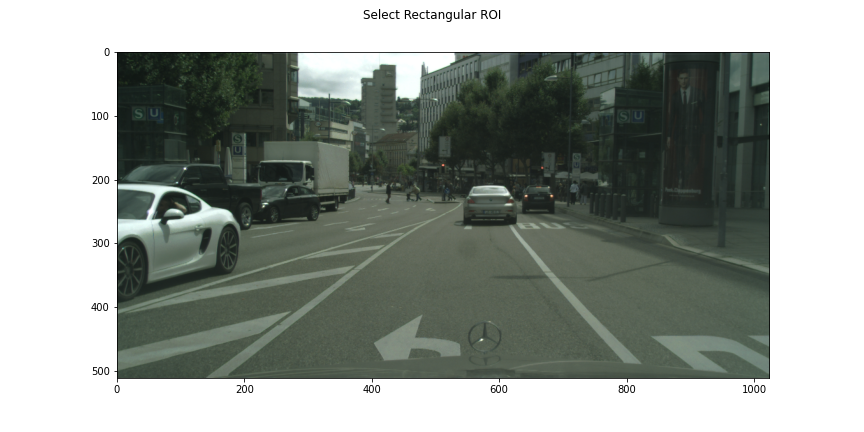

In [ ]:
%matplotlib ipympl
from utils import roi_select
bs = roi_select(data['rgb_img'])

In [ ]:
%matplotlib inline

# convert bounding box coordinates to indices 
roi_indices = bs.get_bbox_indices(scale_factor=(1.0/32))

# select attention for selected ROI
roi_attn = data['attn'][0][0]
roi_attn = rearrange(roi_attn, '(qh qw) (kh kw) -> kh kw (qh qw)', qh=128, qw=256, kh=16, kw=32)
roi_attn = roi_attn[roi_indices['min_y'] : roi_indices['max_y'], roi_indices['min_x'] : roi_indices['max_x'], :]

# rearrange dimensions to make channels first dimension
roi_attn_img = rearrange(roi_attn, 'h w (qh qw) -> (h w) qh qw ', qh=128, qw=256)
print(roi_attn_img.shape)

(4, 128, 256)


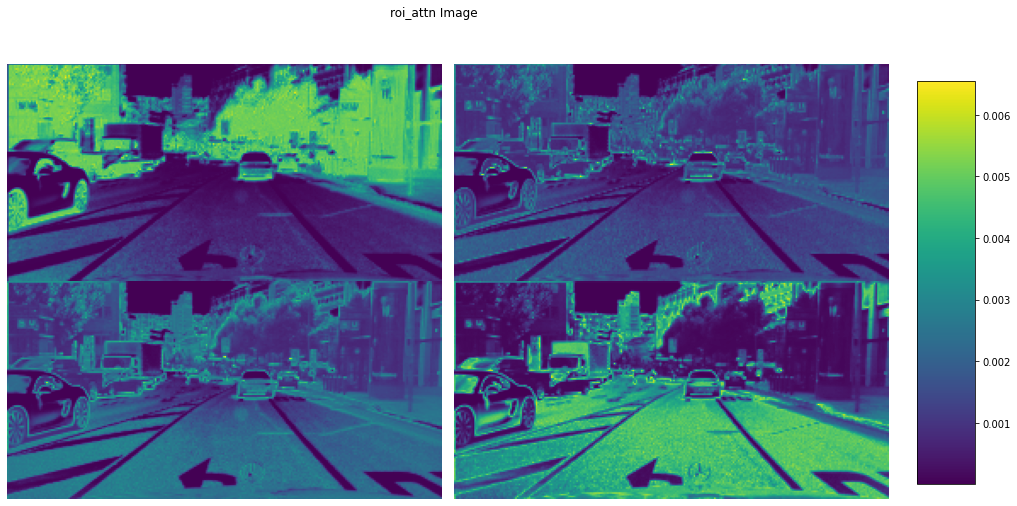

In [ ]:
plot_channels(roi_attn_img, 2, 2, (16, 8), 'roi_attn Image', plot_colorbar=True)